In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc = nn.Linear(784, 256)
        # two separate fc layers for mean and variance
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input x: [B, 784]
        x = F.tanh(self.fc(x)) # [B, latent_dim]
        # Compute mean and logarithm of variance
        mu =  self.fc_mu(x) # [B, latent_dim]
        log_var = self.fc_log_var(x) # [B, latent_dim]
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 784)

    def forward(self, z):
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z
    

class VAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu, log_var = self.encoder(x)
        z = self.reparameterization_trick(mu=mu, var=torch.exp(log_var))
        x_hat = self.decoder(z)
        return x_hat, mu, log_var
    
    def reparameterization_trick(self, mu: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(mu) # sample from N(0,I)
        z = mu + var**0.5 * eps # use sd
        return z
    
    def reconstruction_loss(self, x: torch.Tensor, x_hat: torch.Tensor) -> torch.Tensor:
        """
        We want to maximize the quality of reconstruction (minimize MSE).
        """
        mse = torch.sum((x - x_hat)**2) # by batch
        return mse
    
    def kl_divergence(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        We want to minimize KL divergence between the learned distribution 
        of z-space and the prior distribution of z-space.
        """
        kl_distance = 0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var)) # by batch
        return -kl_distance
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss

In [70]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)) # (x/255 - 0.5) / 0.5
])

data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=data, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    break

  0%|          | 0/468 [00:00<?, ?it/s]


In [71]:
epochs = 10
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat, mu, log_var = model(x) # x_hat: [B, 1, 784]

        reconstruction_loss = model.reconstruction_loss(x=x, x_hat=x_hat)
        kl_divergence = model.kl_divergence(mu=mu, log_var=log_var)
        reg_weights_loss = model.reg_weights_loss_fn(lam=1e-2)
        total_loss = reconstruction_loss + kl_divergence + reg_weights_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch:03d}",
                f"mse={reconstruction_loss.item():.3f}",
                f"kl={kl_divergence.item():.3f}",
                f"reg_weights={reg_weights_loss.item():.3f}",
                f"total_loss={total_loss.item():.3f}"
            )

    print()

epoch=0 batch=000 mse=99335.766 kl=98.641 reg_weights=4.403 total_loss=99438.812


In [5]:
x.size(), x_hat.size(), mu.size(), log_var.size()

(torch.Size([128, 784]),
 torch.Size([128, 784]),
 torch.Size([128, 16]),
 torch.Size([128, 16]))

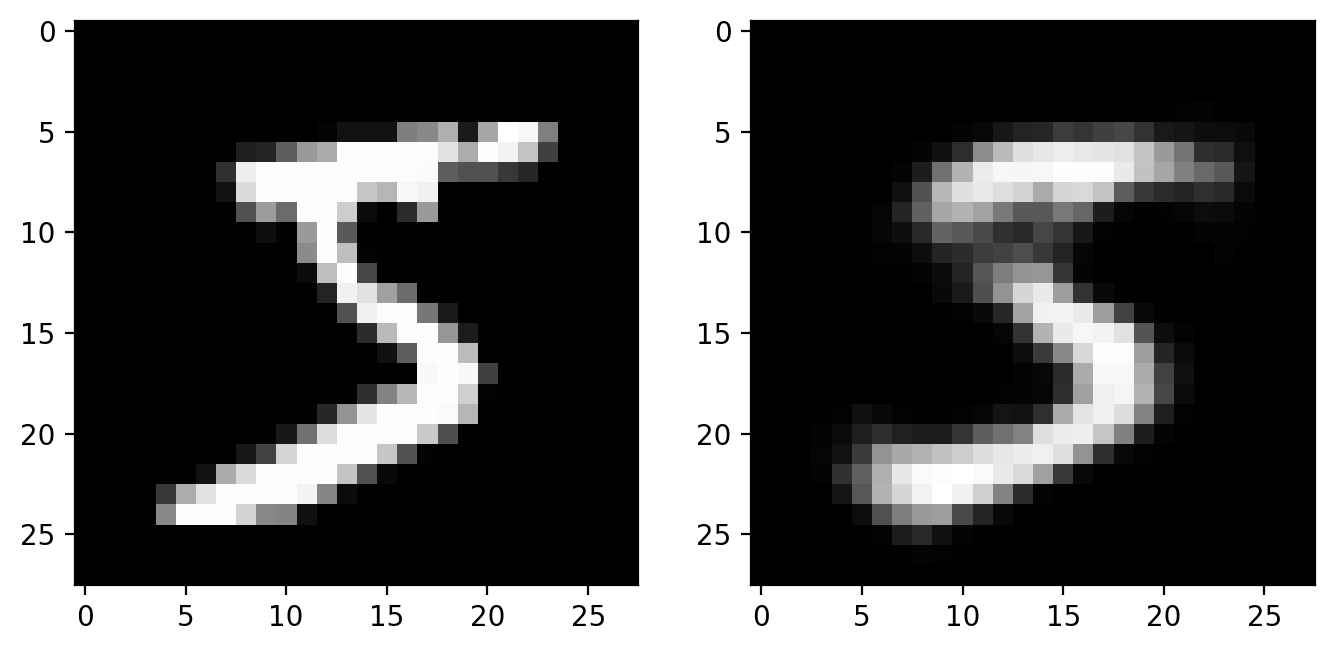

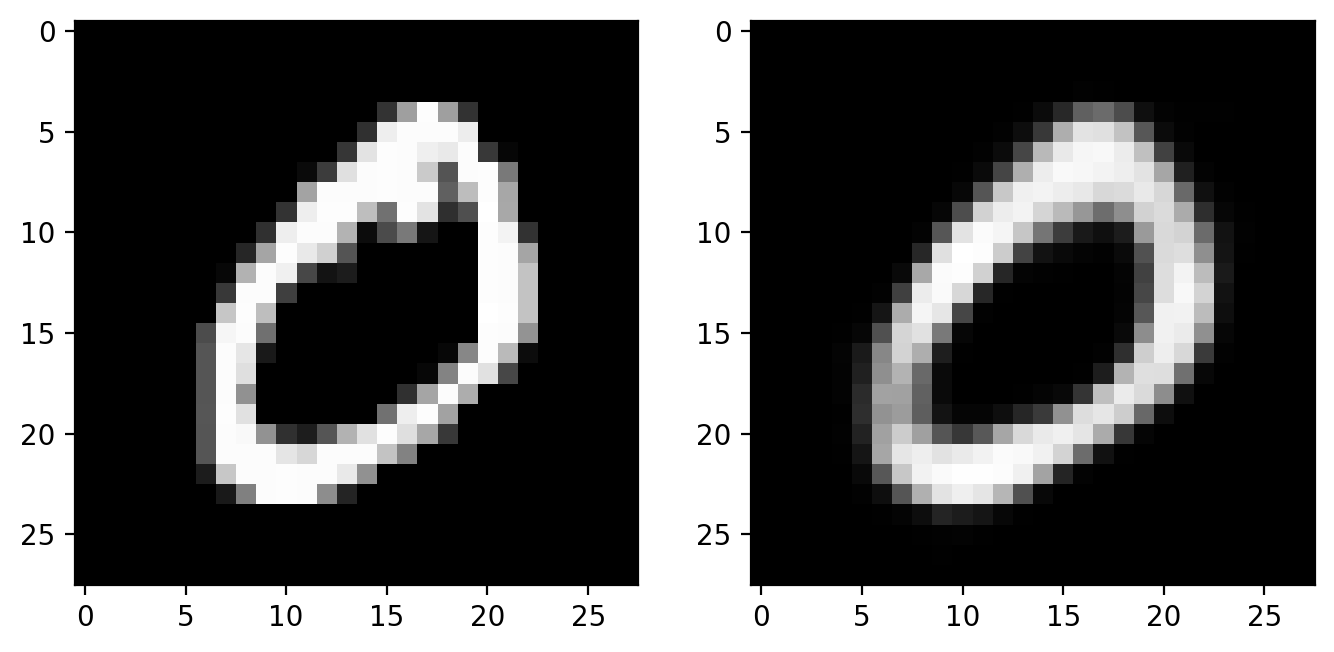

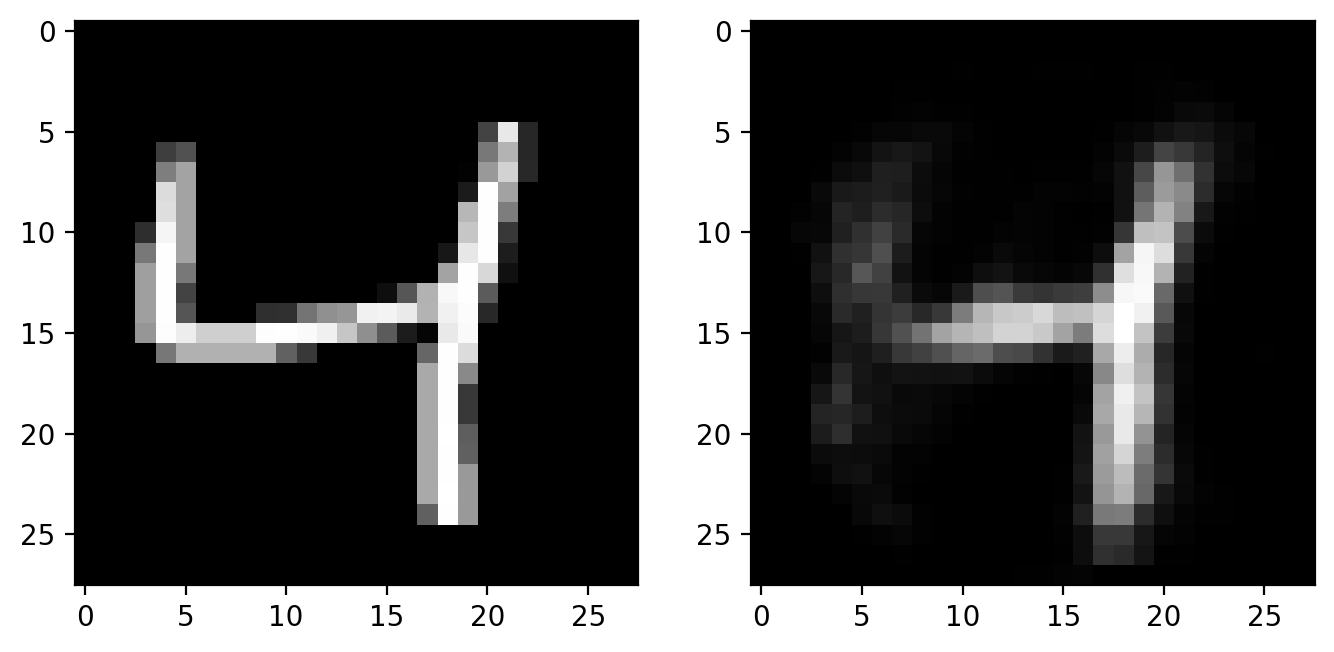

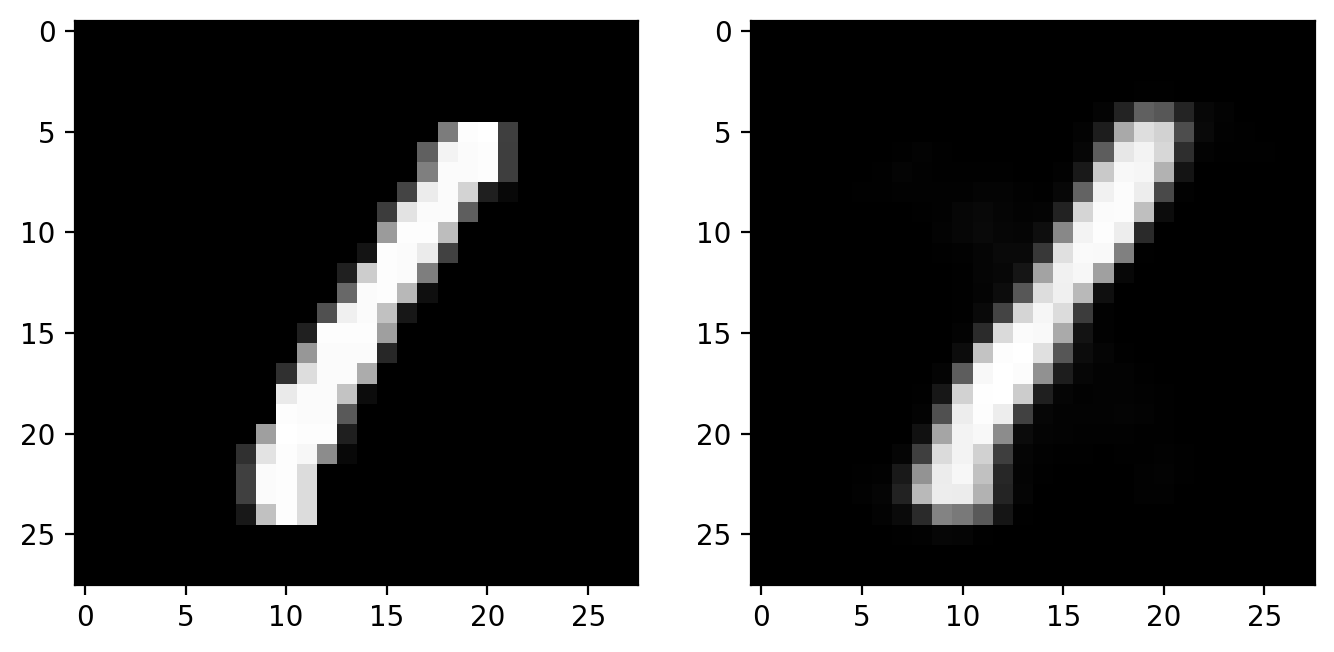

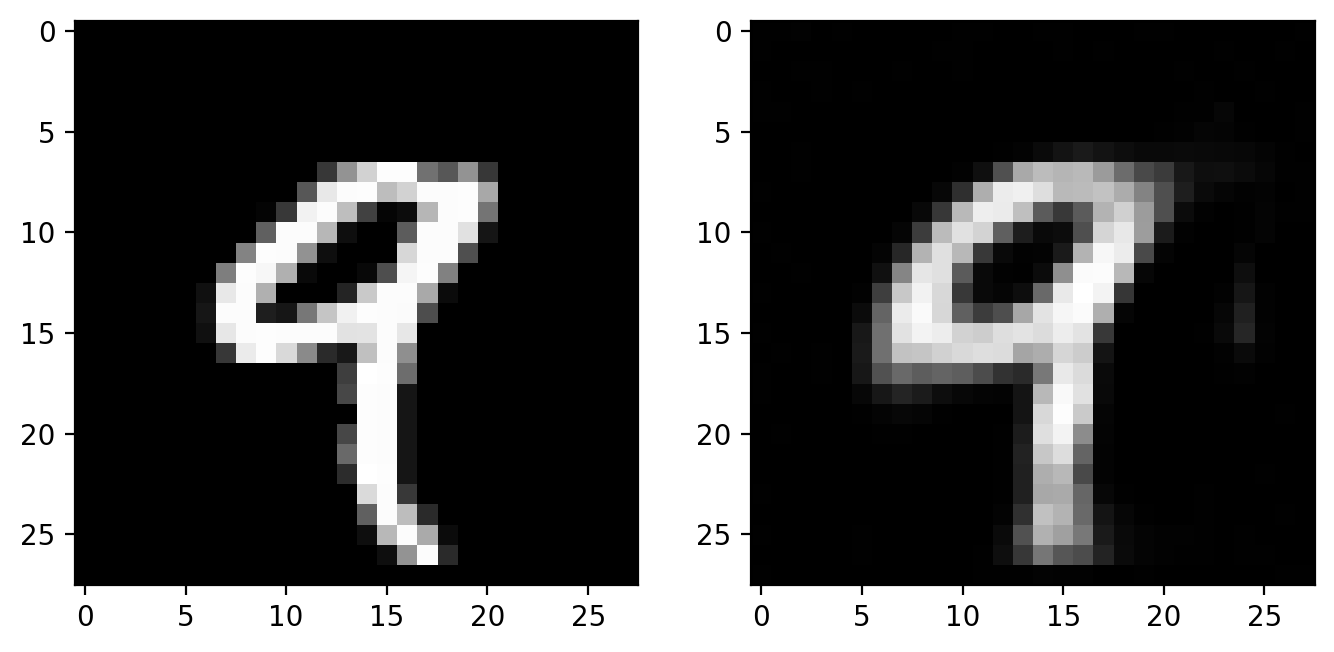

In [19]:
for i in range(5):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

    ex = data[i][0][0]
    ax1.imshow(ex, cmap='gray');

    ex_inp = ex.unsqueeze(0)
    ex_inp = torch.flatten(ex_inp, start_dim=1, end_dim=-1)
    ex_inp_hat, _, _ = model(ex_inp.to(device))
    ax2.imshow(ex_inp_hat.view(28,28).cpu().detach().numpy(), cmap='gray');

    plt.show()

### From noise

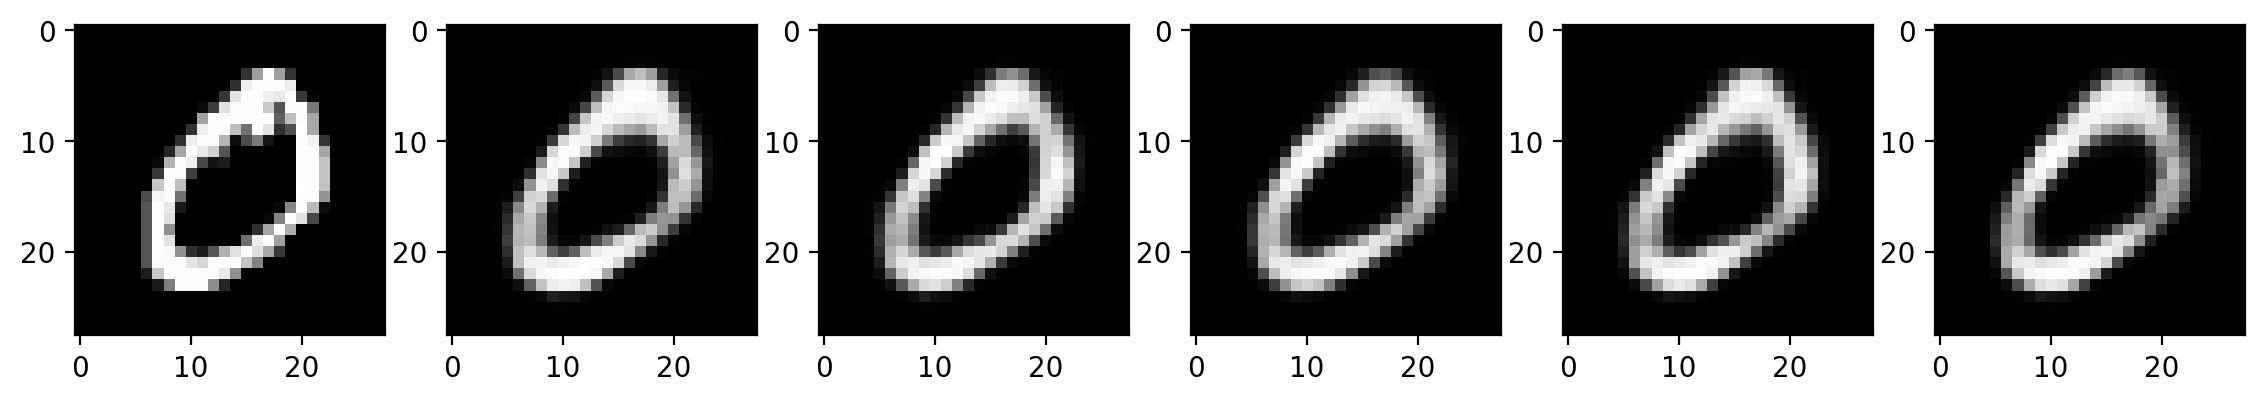

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(14,6))

ex = data[i][0][0]
axes[0].imshow(ex, cmap='gray');

for i in [1,2,3,4,5]:

    ex_inp = ex.unsqueeze(0)
    ex_inp = torch.flatten(ex_inp, start_dim=1, end_dim=-1) # [1, 784]

    # use encoder to output mu and log variance
    mu, log_var = model.encoder(ex_inp)

    # scale
    eps = torch.randn_like(mu)
    z = mu + torch.exp(log_var)**0.5 * eps # use sd

    # use decoder to generate
    ex_inp_hat = model.decoder(z)
    axes[i].imshow(ex_inp_hat.view(28,28).cpu().detach().numpy(), cmap='gray');